In [14]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential, load_model
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import pickle
from keras.callbacks import ModelCheckpoint
from cfg import Config

In [15]:
def check_data():
    if os.path.isfile(config.p_path):
        print('Loadning existing data for {} model'.format(config.mode))
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

def build_rand_feat():
    tmp = check_data()
    if tmp:
        return tmp.data[0], tmp.data[1]
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    print('tqdm: ',n_samples)
    for _ in tqdm(range(int(n_samples))):
        rand_class = np.random.choice(class_dist.index, p = prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('clean/'+file)
        label = df.at[file, 'label']
        rand_index = np.random.randint(0, wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft)
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample)
        y.append(classes.index(label))
    config.min = _min
    config.max = _max
    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y = to_categorical(y, num_classes=10)
    config.data = (X, y)

    with open(config.p_path, 'wb') as handle:
        pickle.dump(config, handle, protocol=2)

    return X, y

In [16]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', strides = (1, 1),padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', strides = (1, 1),padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', strides = (1, 1),padding='same', input_shape=input_shape))
    model.add(Conv2D(128, (3, 3), activation='relu', strides = (1, 1),padding='same', input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model


def get_recurrent_model():
    #shape of data for RNN is (n, time, feat)
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape = input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32, return_sequences=True))
    model.add(LSTM(16, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(128, activation='relu')))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [17]:
df = pd.read_csv('instruments.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

n_samples = 2*int(df['length'].sum())/0.1
prob_dist = class_dist/class_dist.sum()
choices = np.random.choice(class_dist.index, p = prob_dist)

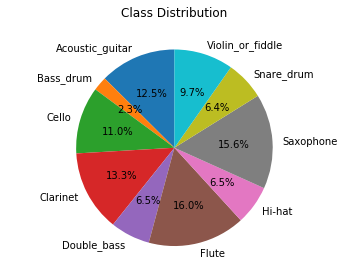

In [18]:
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [22]:
config = Config(mode='time')

if config.mode == 'conv':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()

elif config.mode == 'time':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()

class_weight = compute_class_weight('balanced',np.unique(y_flat),y_flat)

Loadning existing data for time model
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 9, 128)            72704     
_________________________________________________________________
lstm_12 (LSTM)               (None, 9, 128)            131584    
_________________________________________________________________
lstm_13 (LSTM)               (None, 9, 64)             49408     
_________________________________________________________________
lstm_14 (LSTM)               (None, 9, 32)             12416     
_________________________________________________________________
lstm_15 (LSTM)               (None, 9, 16)             3136      
_________________________________________________________________
dropout_4 (Dropout)          (None, 9, 16)             0         
_________________________________________________________________
time_distributed

In [23]:
print(X.shape)
print(input_shape)
print(y.shape)
print(y_flat[1])

(6760, 9, 13)
(9, 13)
(6760, 10)
0


In [21]:
input_shape = (X.shape[1], X.shape[2], 1)
model = get_conv_model()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 9, 13, 16)         160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 13, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 13, 64)         18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 13, 128)        73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 6, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 6, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3072)            

In [24]:
checkpoint = ModelCheckpoint(config.model_path, monitor='val_acc', verbose=1, mode = 'max', save_best_only=True, save_weights_only=False, period=1)
print('class_weight: ',class_weight)

model.fit(X, y, epochs=20, batch_size=32, shuffle=True, validation_split=0.1, callbacks = [checkpoint])
model.save(config.model_path)

class_weight:  [1.2037037  1.01197605 0.81800581 1.08611825 1.015625   0.80094787
 1.01807229 1.21582734]

Train on 6084 samples, validate on 676 samples
Epoch 1/20
6084/6084 [==============================] - 4s 683us/step - loss: 2.1190 - acc: 0.1466 - val_loss: 2.0702 - val_acc: 0.1716

Epoch 00001: val_acc improved from -inf to 0.17160, saving model to models/time.model
Epoch 2/20
6084/6084 [==============================] - 3s 500us/step - loss: 1.9401 - acc: 0.1987 - val_loss: 1.8438 - val_acc: 0.2781

Epoch 00002: val_acc improved from 0.17160 to 0.27811, saving model to models/time.model
Epoch 3/20
6084/6084 [==============================] - 3s 498us/step - loss: 1.7732 - acc: 0.2472 - val_loss: 1.7427 - val_acc: 0.3077

Epoch 00003: val_acc improved from 0.27811 to 0.30769, saving model to models/time.model
Epoch 4/20
6084/6084 [==============================] - 3s 489us/step - loss: 1.6797 - acc: 0.3031 - val_loss: 1.6082 - val_acc: 0.4009

Epoch 00004: val_acc improved from

OSError: Unable to create file (unable to open file: name = 'testmodels/time.model', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

In [30]:
checkpoint = ModelCheckpoint(config.model_path, monitor='val_acc', verbose=1, mode = 'max', save_best_only=True, save_weights_only=False, period=1)
print('class_weight: ',class_weight)
model = load_model('models/time.model')
model.fit(X, y, epochs=20, batch_size=32, shuffle=True, validation_split=0.1, callbacks = [checkpoint])
model.save(config.model_path)

class_weight:  [0.7966204  4.35643564 0.91507799 0.73333333 1.52249135 0.63446287
 1.5932408  0.64642507 1.52866242 1.00303951]
Train on 23760 samples, validate on 2640 samples
Epoch 1/20
23760/23760 [==============================] - 13s 541us/step - loss: 0.1623 - acc: 0.9456 - val_loss: 0.2256 - val_acc: 0.9333

Epoch 00001: val_acc improved from -inf to 0.93333, saving model to models/time.model
Epoch 2/20
23760/23760 [==============================] - 12s 487us/step - loss: 0.1448 - acc: 0.9500 - val_loss: 0.2358 - val_acc: 0.9292

Epoch 00002: val_acc did not improve from 0.93333
Epoch 3/20
23760/23760 [==============================] - 12s 487us/step - loss: 0.1491 - acc: 0.9498 - val_loss: 0.2836 - val_acc: 0.9114

Epoch 00003: val_acc did not improve from 0.93333
Epoch 4/20
23760/23760 [==============================] - 13s 544us/step - loss: 0.1478 - acc: 0.9505 - val_loss: 0.2103 - val_acc: 0.9322

Epoch 00004: val_acc did not improve from 0.93333
Epoch 5/20
23760/23760 [===

In [31]:
checkpoint = ModelCheckpoint(config.model_path, monitor='val_acc', verbose=1, mode = 'max', save_best_only=True, save_weights_only=False, period=1)
print('class_weight: ',class_weight)
model = load_model('models/time.model')
model.fit(X, y, epochs=20, batch_size=32, shuffle=True, validation_split=0.1, callbacks = [checkpoint])
model.save(config.model_path)

class_weight:  [0.7966204  4.35643564 0.91507799 0.73333333 1.52249135 0.63446287
 1.5932408  0.64642507 1.52866242 1.00303951]
Train on 23760 samples, validate on 2640 samples
Epoch 1/20
23760/23760 [==============================] - 13s 564us/step - loss: 0.0966 - acc: 0.9663 - val_loss: 0.1839 - val_acc: 0.9409

Epoch 00001: val_acc improved from -inf to 0.94091, saving model to models/time.model
Epoch 2/20
23760/23760 [==============================] - 11s 480us/step - loss: 0.1086 - acc: 0.9647 - val_loss: 0.2252 - val_acc: 0.9265

Epoch 00002: val_acc did not improve from 0.94091
Epoch 3/20
23760/23760 [==============================] - 12s 507us/step - loss: 0.1056 - acc: 0.9635 - val_loss: 0.2010 - val_acc: 0.9314

Epoch 00003: val_acc did not improve from 0.94091
Epoch 4/20
23760/23760 [==============================] - 13s 533us/step - loss: 0.0906 - acc: 0.9688 - val_loss: 0.2449 - val_acc: 0.9193

Epoch 00004: val_acc did not improve from 0.94091
Epoch 5/20
23760/23760 [===